In [2]:
#Installing packages
!pip install yfinance
!pip install arch
from datetime import date 
import yfinance as yf  #Package to extract data from yahoofinance.com
import pandas as pd    #Package to process data in dataframes
import math            #Package to assess N/A
import numpy as np     #Package to compute returns
from dateutil.relativedelta import relativedelta #Package to compute the rolling windows
import matplotlib.pyplot as plt  #Package to plot series
import  statsmodels.api as sm   #Package to run an OLS regression on the log_prices to establish cointegration
from arch.unitroot import PhillipsPerron #Package to test the stationarity of the residuals



In [357]:
#Function to save data extracted from yahoo finance as a cvs file
def SaveData(df,dataname):
    df.to_csv('./'+dataname+'.csv')

#####################################################################################################
#Function to extract data 
#####################################################################################################
#Function to extract the data from yahoo finance
def getData(tick):
    ticker = yf.Ticker(tick)
    dataname=tick
    
    #Extracting the closing price 
    data = ticker.history(start = start_date,end=end_date)
    data = data["Close"]
    
    #Extracting the dividends and splits
    div_split=ticker.actions
    
    #Data processing the closing price to take into account stock splits
    counter_1 = 0
    for price in data[:len(data)]:
        str_1 = data.index[counter_1]
        counter_2 = 0
        for day in div_split["Dividends"][:len(div_split["Dividends"])]:
            str_2 = div_split["Dividends"].index[counter_2]
            if str_1 == str_2:
                ratio = div_split["Stock Splits"][counter_2]
                if ratio!=0:
                    counter_3=counter_1+1
                    for gross_price in data[counter_1+1:len(data)]:
                        gross_price = gross_price*ratio
                        data.iat[counter_3] = gross_price
                        counter_3+=1
            counter_2+=1
        counter_1 += 1
    
    #Data processing the closing price to add back dividends
    counter_1 = 0
    for price in data[:len(data)]:
        str_1 = data.index[counter_1]
        counter_2 = 0
        for day in div_split["Dividends"][:len(div_split["Dividends"])]:
            str_2 = div_split["Dividends"].index[counter_2]
            if str_1 == str_2:
                dividend = div_split["Dividends"][counter_2]
                price = price + dividend
                data.iat[counter_1] = price
            counter_2+=1
        counter_1 += 1
    
    data = pd.DataFrame(data)    
    data.rename(columns={'Close':dataname},inplace =  True)
    return data


#Function to get the first row of available data
def First(data):
    counter=0
    for ele in data:
        if math.isnan(ele)==False:
            break
        counter+=1
    return counter

#Function to fill in the blanks
def Filling(data):
    start = First(data)
    for ele in data[start:len(data)]:
        if math.isnan(ele)==True:
            data.iat[start] = data[start-1]
        start+=1       
    return data


#############################################################################################################
#Functions related to correlation
#############################################################################################################

#Function to determine the max other than 1 
def max_corr(data):
    max_ = -1
    for ele in data : 
        if max_< ele and ele!=1: 
            max_=ele
    return max_
            
#Function that returns the perfect pair for a given list 
def pair_of(data):
    counter = 0 
    for corr in data:
        if corr == max_corr(data):
            break
        counter+=1
    return data.index[counter]

#Function to avoid double pairs and returns a boolean
def check_double(data, row):
    test=False
    for ele in data:
        if set(ele)==set(row):
            test= True
    return test

##############################################################################################################
#Function to compute based on a rolling window
##############################################################################################################

#Function to determine the start date such as we have available information for both stocks
def start_d(data):
    counter=0
    for i in range(0,len(data)):
        ele_1 = data[data.columns[0]][i]
        ele_2 = data[data.columns[1]][i]
        if math.isnan(ele_1)== False and math.isnan(ele_2)==False:
            break
        counter+=1
    return counter
    
#Function to determine the 6 months date
def resize_months(start_date, data, number_months):
    start_date = data.index[start_date]
    end_date = start_date+relativedelta(months=+number_months)
    int_ = data.index.searchsorted(end_date)+1
    return int_

###############################################################################################################
#Function used in pair construction
###############################################################################################################

#Function that take as a parameter a row of the pair dataframe and constructs a dataframe with their returns
def pair_return(data,row):
    df= pd.concat([data[row[0]],data[row[1]]],axis=1)
    return df

#Function that retruns the index number of a date
def index_number(date,data):
    df_1 = data.copy()
    df = pd.DataFrame(df_1)
    df['A']=np.arange(len(df))
    return df['A'][date]

#Function to clean up data in order to avoid having two values for the same date
def clean_up_data(data):
    return data.reset_index().drop_duplicates(subset='index').set_index('index')
    
#Function that returns the corrected merged data frame of moving average and rolling window correlation
def avr_corr(avr,corr):
    df = pd.concat([avr,corr],axis=1)
    return df.dropna(axis=0)

In [567]:
#Defining ticker list + end and start date
ticker_list = ['NFLX','FB2A.DE','AAPL','BKNG34.SA','SU.PA','TKWY.AS',]
               
start_date = "1990-01-01"
end_date = "2021-03-31"

#Extracting the closing prices from yahoofinance.com and making adjustment on them
adj_close = pd.DataFrame(getData(ticker_list[0]))
for tick in ticker_list[1:len(ticker_list)]:
    print(tick)
    adj_close= pd.concat([adj_close,getData(tick)],axis=1)
    
#Cleaning up the data by filling in the gaps
for ticker in ticker_list:
    Filling(adj_close[ticker])

#Computing the weekly adjusted closing prices
adj_close_w = adj_close.resample("1W").last()
    
#Computing returns: 
daily_ret = np.log(adj_close) - np.log(adj_close.shift(1))
weekly_ret = np.log(adj_close_w) - np.log(adj_close_w.shift(1))

#Computing the in and out of sample dataframes
in_sample_returns = weekly_ret[datetime.datetime(1990,1,2):datetime.datetime(2016,12,28)].dropna(axis=1,how='all')
out_sample_returns = weekly_ret[datetime.datetime(2016,12,29):]


FB2A.DE
AAPL
BKNG34.SA
SU.PA
TKWY.AS


In [569]:
SaveData(adj_close_w,"Adjusted_weekly_closing_price")
SaveData(weekly_ret,"weekly_returns")

In [574]:
#Function that returns a dataframe containing all the pairs based on correlation
def pairs(returns):
    corr_matrix = returns.corr(method='spearman')
    matrix=[]
    pair_1 = corr_matrix.index[0]
    pair_2 = pair_of(corr_matrix[pair_1])
    row = [pair_1,pair_2]
    matrix.append(row)
    for ele in corr_matrix.index:
        pair_1 = ele
        pair_2 = pair_of(corr_matrix[pair_1])
        row = [pair_1,pair_2]
        if check_double(matrix,row)==False:
            matrix = np.vstack([matrix,row])
    return matrix      

#Function to compute rolling correlation for a six month period takes as parameter pair return
def rolling_corr(data,start):
    corr_6m =[]
    index=[]
    for start_date in range(start,len(data)-27):
        end_date = resize_months(start_date,data,6)
        index.append(data.index[end_date-1])
        window = data[start_date:end_date]
        corr = window.corr(method='spearman')[data.columns[0]][data.columns[1]]
        corr_6m.append(corr)
    #Reindexing
    corr_6m = pd.DataFrame(corr_6m)
    for i in range(0,len(corr_6m)):
        corr_6m.rename(index={i:index[i]},inplace = True)
    corr_6m.rename(columns={0:data.columns[0]+'-'+data.columns[1]},inplace = True)
    return clean_up_data(corr_6m)
 
#Function to compute the moving average of the series takes as a parameter the rolling correlation
def moving_average(rolling_cor):
    moving_aver = []
    index=[]
    for start_date in range(0,len(rolling_cor)-26):
        end_date = resize_months(start_date,rolling_cor,6)
        index.append(rolling_cor.index[end_date-1])
        window = rolling_cor[start_date:end_date]
        moving_aver.append(window.mean())
    #Reindexing
    moving_aver = pd.DataFrame(moving_aver)
    for i in range(0,len(moving_aver)):
        moving_aver.rename(index={i:index[i]},inplace = True)
    moving_aver.rename(columns={rolling_cor.columns[0]:rolling_cor.columns[0]+' - Avrg'},inplace = True)
    return clean_up_data(moving_aver)

#Function that executes the trading strategy of the pair
def trading_corr(row_of_pair, delta, data):
    
    #Stocking data in respective variable
    returns = pair_return(data,row_of_pair)
    prices = pair_return(adj_close_w,row_of_pair)
    averg_corrl = avr_corr(rolling_corr(data,start_d(data)),moving_average(rolling_corr(data,start_d(data))))
    str = returns.columns[0]+'-'+returns.columns[1]
    rolling_correlation = averg_corrl[str] 
    moving_avrg = averg_corrl[str+' - Avrg']
    
    #Initializing
    counter = 0
    weights_1 = 0
    weights_2 = 0
    portfolio = []
    
    #Excuting the trade for the given period
    for i in range(0,len(rolling_correlation)):
        
        #Stocking info in  respective variable
        average = moving_avrg[moving_avrg.index[counter]]
        correlation = rolling_correlation[rolling_correlation.index[i]]
        date = rolling_correlation.index[i]
        return_1 = returns[row_of_pair[0]][date]
        return_2 = returns[row_of_pair[1]][date]
        price_1 = prices[row_of_pair[0]][date]
        price_2 = prices[row_of_pair[1]][date]
        counter += 1
        
        #Readjustig
        if correlation < average + delta:
            if return_1 > return_2: 
                weights_1 += -1
                weights_2 += 1
            else:
                weights_1 += 1
                weights_2 += -1 
                
        elif correlation > average + delta:
            if return_1 < return_2: 
                weights_1 += -1
                weights_2 += 1
            else:
                weights_1 += 1
                weights_2 += -1

        portfolio.append(weights_1*price_1 + weights_2*price_2)
    
    #Reindexing
    portfolio = pd.DataFrame(portfolio)
    for i in range(0,len(portfolio)):
        portfolio.rename(index={i:averg_corrl.index[i]},inplace = True)
    portfolio.rename(columns={0:str+' - Portfolio Returns'},inplace = True)

    #Computing the return of the portfolio
    return_portfolio = np.log(portfolio) - np.log(portfolio.shift(1))
    return_portfolio = pd.DataFrame(return_portfolio).fillna(0)
    return return_portfolio


<ipython-input-574-3103e2924657>:106: RuntimeWarning: divide by zero encountered in log
  return_portfolio = np.log(portfolio) - np.log(portfolio.shift(1))
<ipython-input-574-3103e2924657>:106: RuntimeWarning: invalid value encountered in log
  return_portfolio = np.log(portfolio) - np.log(portfolio.shift(1))
<ipython-input-574-3103e2924657>:106: RuntimeWarning: divide by zero encountered in log
  return_portfolio = np.log(portfolio) - np.log(portfolio.shift(1))
<ipython-input-574-3103e2924657>:106: RuntimeWarning: invalid value encountered in log
  return_portfolio = np.log(portfolio) - np.log(portfolio.shift(1))
<ipython-input-574-3103e2924657>:106: RuntimeWarning: invalid value encountered in log
  return_portfolio = np.log(portfolio) - np.log(portfolio.shift(1))
<ipython-input-574-3103e2924657>:106: RuntimeWarning: divide by zero encountered in log
  return_portfolio = np.log(portfolio) - np.log(portfolio.shift(1))
<ipython-input-574-3103e2924657>:106: RuntimeWarning: invalid value

<AxesSubplot:>

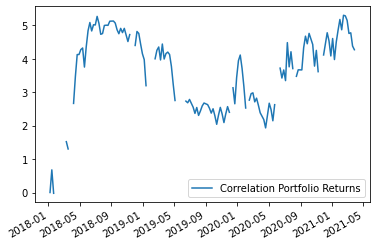

In [580]:
#Executing the pair trading strategy
#Determining the pair trade based on the first two years of observation
matrix = pairs(in_sample_returns)

#Looping trough the pairs and summing the returns
portfolio_ret = pd.DataFrame(trading_corr(matrix[0],0.1,pair_return(out_sample_returns,matrix[0])))
for row in matrix[1:]: 
    portfolio_ret = pd.concat([portfolio_ret,trading_corr(row,0.1,pair_return(out_sample_returns,row))],axis=1)
portfolio_ret = pd.DataFrame(portfolio_ret.sum(axis=1)) 
portfolio_ret.rename(columns={0:'Correlation Portfolio Returns'},inplace = True)
portfolio_ret[np.isfinite(portfolio_ret)].cumsum().plot()    
#plt.plot(portfolio_ret)

In [617]:
#Cointegration

#Function that takes as parameters ajd closing prices and returns a matrix with the most suited pairs
def cointegration (ajd_close_w):
    adj_close = np.log(adj_close_w)
    matrix = ["_","_"]
    for ticker_1 in adj_close.columns:
        #Dataframe to stock all p_values
        p_value=[]
        
        #Looping through tickers 
        for ticker_2 in adj_close.columns:
            
            #Computing the p_value for each other stock
            if ticker_1 != ticker_2:
                data_coint = pair_return(adj_close,[ticker_1,ticker_2]).dropna(axis=0)
                Y =  data_coint[ticker_1]
                X = data_coint[ticker_2]
                X = sm.add_constant(X)
                ols_regression = sm.OLS(Y,X).fit()
                residuals = Y - ols_regression.fittedvalues
                if math.isnan(residuals.sum(axis=0))==False and len(residuals.dropna(axis=0))>4:
                    pp = PhillipsPerron(residuals.dropna(axis=0))
                    p_value.append([ticker_2,pp.pvalue])
        
        #Deteminin the most cointegrated ticker_2 with ticker_1
        p_value = pd.DataFrame(p_value)
        for i in range(len(p_value[1])): 
            if p_value[1][i] == p_value[1].max():
                row = [ticker_1,p_value[0][i]]
                
        #Stocking the pairs in a matrix
        if check_double(matrix,row)==False:
            matrix = np.vstack([matrix,row])
            
    return matrix[1:]
             
           
print(cointegration(adj_close_w))        


[['NFLX' 'BKNG34.SA']
 ['FB2A.DE' 'SU.PA']
 ['AAPL' 'TKWY.AS']
 ['BKNG34.SA' 'TKWY.AS']
 ['SU.PA' 'TKWY.AS']]
